<a href="https://colab.research.google.com/github/Chava-Sai/Human-Vs-AI/blob/main/Human_VS_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task -  1 Attempt - 1

In [ ]:
!nvidia-smi

Sun Oct  5 22:59:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             49W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import torch, os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

Device: cuda


In [ ]:
# ==== GPU sanity check (prints which GPU we got) ====
!nvidia-smi

# ==== Install dependencies (CUDA 12.x wheel for torch; adjust if needed) ====
# We keep versions stable for reproducibility.
!pip -q install torch --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install transformers==4.44.2 pandas pyarrow scikit-learn tqdm

# ==== (Optional) Restart Uvicorn/Colab's runtime output if it complains; usually not needed ====

# ==== Mount Google Drive so we can load/save datasets and checkpoints persistently ====
from google.colab import drive  # Colab helper to mount Drive
drive.mount('/content/drive', force_remount=True)  # Prompts you to authorize once

Sun Oct  5 22:59:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             49W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# ==== Silence tokenizer parallelism warning (must be set BEFORE importing transformers) ====
import os  # OS/env utils
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # avoids fork/parallelism deadlock warnings

# ==== Standard imports ====
import random  # seeds
from dataclasses import dataclass  # clean config container
from typing import Dict, List, Optional, Tuple  # type hints

import numpy as np  # numerics
import pandas as pd  # parquet I/O
from tqdm import tqdm  # progress bars

# ==== Metrics from scikit-learn ====
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# ==== PyTorch core ====
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# ==== Hugging Face Transformers ====
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

# ==== Confirm device ====
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ==== Reproducibility helper ====
def set_seed(seed: int) -> None:
    random.seed(seed)                  # Python RNG
    np.random.seed(seed)               # NumPy RNG
    torch.manual_seed(seed)            # PyTorch CPU RNG
    torch.cuda.manual_seed_all(seed)   # All visible GPUs
    torch.backends.cudnn.deterministic = True  # Deterministic convs
    torch.backends.cudnn.benchmark = False     # Disable autotuner (more reproducible)

# ==== Configuration dataclass (you can edit paths & hyperparams here) ====
@dataclass
class Config:
    # ---- PATHS: set these to your files in Drive ----
    # Example: put your parquet files at /content/drive/MyDrive/semeval_taskA/
    data_dir: str = "/content/drive/MyDrive/SemEval-2026-Task13"
    train_parquet: str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_training_set_1.parquet"
    val_parquet: str   = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_validation_set.parquet"
    test_parquet: str  = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet"  # optional; comment if not available

    # ---- Model (allowed general-purpose code model) ----
    model_name: str = "microsoft/codebert-base"

    # ---- Tokenization / batching ----
    max_length: int = 512             # truncate long code sequences
    train_batch_size: int = 16        # A100 can handle 16 easily; drop to 8 on T4
    eval_batch_size: int = 32         # evaluation can be larger
    gradient_accumulation_steps: int = 1  # set >1 if you want a bigger effective batch

    # ---- Optimization ----
    epochs: int = 3                   # start small; we’ll iterate later
    lr: float = 2e-5                  # good LR for transformer fine-tune
    weight_decay: float = 0.01        # AdamW regularization
    warmup_ratio: float = 0.1         # % of steps for LR warmup
    max_grad_norm: float = 1.0        # gradient clipping

    # ---- Dataloading ----
    num_workers: int = 2              # Colab-friendly; bump to 4 if stable

    # ---- Reproducibility ----
    seed: int = 42

    # ---- Evaluation settings (normalized lang names) ----
    seen_languages: Tuple[str, ...] = ("cpp", "python", "java")
    unseen_languages: Tuple[str, ...] = ("go", "php", "csharp", "c", "javascript")
    seen_domains: Tuple[str, ...] = ("algorithmic",)
    unseen_domains: Tuple[str, ...] = ("research", "production")

    # ---- Output directories ----
    out_dir: str = "/content/drive/MyDrive/semeval_taskA_outputs"
    ckpt_name: str = "taskA_codebert_best.pt"

cfg = Config()             # instantiate config
set_seed(cfg.seed)         # set seeds
os.makedirs(cfg.out_dir, exist_ok=True)  # make sure output dir exists
print("Outputs will be saved to:", cfg.out_dir)

Device: cuda
Outputs will be saved to: /content/drive/MyDrive/semeval_taskA_outputs


In [ ]:
# ==== Normalize language spellings to the set we expect ====
def normalize_language(s: str) -> str:
    if s is None:
        return "unknown"                # fallback if missing
    t = str(s).strip().lower()          # canonicalize case/whitespace
    # common aliases
    if t in {"py", "py3", "python3"}: t = "python"
    if t in {"c++", "cpp"}: t = "cpp"
    if t in {"c#", "cs", "csharp"}: t = "csharp"
    if t in {"js", "javascript", "node"}: t = "javascript"
    if t in {"golang", "go"}: t = "go"
    if t in {"c"}: t = "c"
    if t in {"java"}: t = "java"
    if t in {"php"}: t = "php"
    return t

# ==== Read parquet with expected columns and inject domain if absent ====
def read_parquet_expect_cols(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path)                         # load parquet -> DataFrame
    required = {"code", "generator", "label", "language"}  # minimal set we rely on
    missing = required - set(df.columns)               # check columns
    if missing:
        raise ValueError(f"{path} missing required columns: {missing}")

    df = df.copy()                                     # avoid mutating the original
    df["language"] = df["language"].apply(normalize_language)  # normalize language
    if "domain" not in df.columns:                     # many task A files lack 'domain'
        df["domain"] = "algorithmic"                   # set default training domain
    df["code"] = df["code"].astype(str)                # ensure code is string
    return df

# ==== Map label to explicit binary 0/1 (0=human, 1=machine) ====
def map_labels_to_binary(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if np.issubdtype(df["label"].dtype, np.number):    # numeric labels present
        df["label_bin"] = df["label"].astype(int)      # coerce to int
        uniq = set(df["label_bin"].unique().tolist())  # check only {0,1}
        if not uniq.issubset({0, 1}):
            raise ValueError(f"Numeric labels must be 0/1; found {uniq}")
        return df
    # textual labels
    def to_bin(x):
        s = str(x).strip().lower()
        if s in {"0", "human"}: return 0
        if s in {"1", "machine", "ai", "generated", "llm"}: return 1
        raise ValueError(f"Unexpected label: {x}")
    df["label_bin"] = df["label"].apply(to_bin)
    return df

In [ ]:
# ==== PyTorch Dataset that tokenizes on-the-fly ====
class CodeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int):
        self.df = df.reset_index(drop=True)       # clean 0..N-1 indexing
        self.tok = tokenizer                      # HF tokenizer to encode text
        self.max_length = max_length              # truncation length

    def __len__(self) -> int:
        return len(self.df)                       # number of samples

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]                   # get row
        code = row["code"]                        # raw code text
        label = int(row["label_bin"])             # binary label 0/1
        lang = row["language"]                    # meta: language
        dom  = row["domain"]                      # meta: domain (default algorithmic)

        prefix = f"<lang:{lang}>\n"               # tiny hint for encoder (language tag)
        text = prefix + code                      # prepend and concatenate

        enc = self.tok(                           # tokenize with truncation + fixed padding
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),       # [seq_len]
            "attention_mask": enc["attention_mask"].squeeze(0),  # [seq_len]
            "label": torch.tensor(label, dtype=torch.long),  # scalar label
            "language": lang,                                # pass-through meta
            "domain": dom                                    # pass-through meta
        }
        return item

# ==== Build DataLoaders for train/val/test ====
def build_loaders(cfg):
    tok = AutoTokenizer.from_pretrained(cfg.model_name)  # load tokenizer that matches encoder

    # read + normalize parquet
    train_df = read_parquet_expect_cols(cfg.train_parquet)
    val_df   = read_parquet_expect_cols(cfg.val_parquet)
    train_df = map_labels_to_binary(train_df)
    val_df   = map_labels_to_binary(val_df)

    # optional test parquet (for generating probs)
    test_df = None
    if os.path.exists(cfg.test_parquet):
        test_df = read_parquet_expect_cols(cfg.test_parquet)
        if "label" in test_df.columns:
            try:
                test_df = map_labels_to_binary(test_df)  # if labels exist; else fallback
            except Exception:
                test_df["label_bin"] = 0                 # placeholder not used
        else:
            test_df["label_bin"] = 0

    # create datasets
    train_ds = CodeDataset(train_df, tok, cfg.max_length)
    val_ds   = CodeDataset(val_df,   tok, cfg.max_length)
    test_ds  = CodeDataset(test_df,  tok, cfg.max_length) if test_df is not None else None

    # create loaders; Colab-friendly worker count; pin_memory for faster H2D
    train_loader = DataLoader(train_ds, batch_size=cfg.train_batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=cfg.eval_batch_size,  shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=cfg.eval_batch_size,  shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True) if test_ds is not None else None

    return tok, train_loader, val_loader, test_loader

In [ ]:
# ==== Simple binary classifier with CodeBERT encoder ====
class CodeBERTBinaryClassifier(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()                                          # init base class
        self.encoder = AutoModel.from_pretrained(model_name)        # load pretrained encoder
        hidden = self.encoder.config.hidden_size                    # e.g., 768
        self.drop = nn.Dropout(0.1)                                 # light regularization
        self.cls  = nn.Linear(hidden, 1)                            # 1 logit (binary)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)  # encoder forward
        cls_vec = out.last_hidden_state[:, 0, :]                                  # take [CLS]-like token
        x = self.drop(cls_vec)                                                    # dropout
        logits = self.cls(x).squeeze(-1)                                          # [B] logits
        return logits

In [ ]:
# ==== overall metrics ====
def compute_metrics(y_true: List[int], y_prob: List[float]) -> Dict[str, float]:
    y_true = np.asarray(y_true).astype(int)       # ground-truth labels
    y_prob = np.asarray(y_prob).astype(float)     # prob of class "machine" (1)
    try:
        auroc = roc_auc_score(y_true, y_prob)     # AUROC
    except ValueError:
        auroc = float("nan")                      # undefined if only one class
    auprc = average_precision_score(y_true, y_prob)  # area under PR curve
    y_pred = (y_prob >= 0.5).astype(int)          # simple 0.5 threshold
    f1 = f1_score(y_true, y_pred, average="macro")# macro-F1
    return {"auroc": auroc, "auprc": auprc, "macro_f1": f1}

# ==== per-setting metrics (i)–(iv) using language & domain ====
def compute_setting_metrics(meta: List[Tuple[str, str]], y_true: List[int], y_prob: List[float], cfg) -> Dict[str, Dict[str, float]]:
    metas = np.array(meta)                        # shape [N, 2] of (lang, dom)
    langs = metas[:, 0]
    doms  = metas[:, 1]

    def mask(seen_lang: bool, seen_dom: bool):
        lm = np.isin(langs, cfg.seen_languages) if seen_lang else np.isin(langs, cfg.unseen_languages)
        dm = np.isin(doms,  cfg.seen_domains)   if seen_dom  else np.isin(doms,  cfg.unseen_domains)
        return lm & dm

    masks = {
        "i":   mask(True,  True),
        "ii":  mask(False, True),
        "iii": mask(True,  False),
        "iv":  mask(False, False),
    }

    res = {}
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    for k, m in masks.items():
        if m.sum() == 0:
            res[k] = {"auroc": float("nan"), "auprc": float("nan"), "macro_f1": float("nan")}
        else:
            res[k] = compute_metrics(y_true[m].tolist(), y_prob[m].tolist())
    return res

In [ ]:
# ==== one training epoch ====
def train_one_epoch(model, loader, optimizer, scheduler, scaler, cfg):
    model.train()                              # enable dropout etc.
    total_loss, steps = 0.0, 0                 # track loss

    # tqdm wrapper shows a progress bar
    for i, batch in enumerate(tqdm(loader, desc="Training", ncols=100)):
        input_ids = batch["input_ids"].to(device, non_blocking=True)     # H2D copy
        attn      = batch["attention_mask"].to(device, non_blocking=True)
        labels    = batch["label"].float().to(device, non_blocking=True)

        # mixed precision autocast (new API) speeds up training on GPU
        with torch.amp.autocast(device_type="cuda", enabled=(device=="cuda")):
            logits = model(input_ids=input_ids, attention_mask=attn)     # forward pass
            loss   = nn.functional.binary_cross_entropy_with_logits(logits, labels)  # BCE-with-logits

        # scale/backprop safely under AMP
        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        # gradient accumulation support
        if (i + 1) % cfg.gradient_accumulation_steps == 0:
            if scaler is not None:
                scaler.unscale_(optimizer)                                 # unscale before clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)   # clip

            if scaler is not None:
                scaler.step(optimizer)                                     # optimizer step
                scaler.update()                                            # update scaler
            else:
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)                          # clear grads
            if scheduler is not None:
                scheduler.step()                                           # advance LR schedule

        total_loss += loss.item()                                          # accumulate loss
        steps += 1                                                         # step count

    return total_loss / max(1, steps)                                      # mean loss for the epoch

# ==== evaluation helper (no grad) ====
@torch.no_grad()
def evaluate(model, loader, cfg):
    model.eval()                                   # eval mode (no dropout)
    probs, labels, metas = [], [], []              # accumulators

    for batch in tqdm(loader, desc="Validating", ncols=100):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attn      = batch["attention_mask"].to(device, non_blocking=True)
        logits    = model(input_ids=input_ids, attention_mask=attn)        # forward
        p         = torch.sigmoid(logits).detach().cpu().numpy().tolist()  # logits -> probs

        probs.extend(p)                                                     # collect
        labels.extend(batch["label"].numpy().tolist())
        metas.extend([(l, d) for l, d in zip(batch["language"], batch["domain"])])

    overall  = compute_metrics(labels, probs)                               # overall metrics
    settings = compute_setting_metrics(metas, labels, probs, cfg)           # per-setting metrics
    return overall, settings, (labels, probs, metas)                        # return preds too for CSV dump

# ==== full fit routine ====
def fit_and_save(cfg):
    # build loaders & tokenizer
    tok, train_loader, val_loader, test_loader = build_loaders(cfg)

    # init model and move to device
    model = CodeBERTBinaryClassifier(cfg.model_name).to(device)

    # optimizer / scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    total_steps = (len(train_loader) * cfg.epochs) // max(1, cfg.gradient_accumulation_steps)  # total optimizer steps
    warmup_steps = int(cfg.warmup_ratio * total_steps)                                        # warmup proportion
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                num_training_steps=total_steps)

    # AMP scaler for CUDA; None on CPU
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    best_f1 = -1.0                            # track best macro-F1
    best_state = None                         # store best weights (CPU copy)

    # training epochs
    for ep in range(1, cfg.epochs + 1):
        print(f"\n===== Epoch {ep}/{cfg.epochs} =====")
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, scaler, cfg)   # train
        overall, settings, _ = evaluate(model, val_loader, cfg)                                # validate

        # log metrics
        print(f"\nTrain loss: {train_loss:.4f}")
        print(f"Val overall: AUROC={overall['auroc']:.4f}  AUPRC={overall['auprc']:.4f}  Macro-F1={overall['macro_f1']:.4f}")
        print("Val settings:")
        for k in ["i", "ii", "iii", "iv"]:
            m = settings[k]
            print(f"  ({k})  AUROC={m['auroc']:.4f}  AUPRC={m['auprc']:.4f}  Macro-F1={m['macro_f1']:.4f}")

        # track & store best state dict by macro-F1
        if overall["macro_f1"] > best_f1:
            best_f1 = overall["macro_f1"]
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            print(f"** New best Macro-F1 = {best_f1:.4f} (checkpoint cached in memory) **")

    # restore best weights before final eval / inference
    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)
        # save to Drive
        ckpt_path = os.path.join(cfg.out_dir, cfg.ckpt_name)
        torch.save(best_state, ckpt_path)
        print(f"\nSaved best checkpoint to: {ckpt_path}")

    # final val evaluation with best model, plus CSV dump for error analysis
    final_overall, final_settings, (v_labels, v_probs, v_metas) = evaluate(model, val_loader, cfg)
    print("\n=== Final Validation (best) ===")
    print(f"Overall: AUROC={final_overall['auroc']:.4f}  AUPRC={final_overall['auprc']:.4f}  Macro-F1={final_overall['macro_f1']:.4f}")
    print("Settings:")
    for k in ["i", "ii", "iii", "iv"]:
        m = final_settings[k]
        print(f"  ({k})  AUROC={m['auroc']:.4f}  AUPRC={m['auprc']:.4f}  Macro-F1={m['macro_f1']:.4f}")

    # write validation predictions CSV
    val_csv = os.path.join(cfg.out_dir, "taskA_val_predictions.csv")
    v_langs = [x[0] for x in v_metas]
    v_doms  = [x[1] for x in v_metas]
    pd.DataFrame({
        "label": v_labels,
        "prob_machine": v_probs,
        "language": v_langs,
        "domain": v_doms
    }).to_csv(val_csv, index=False)
    print(f"Wrote validation predictions to: {val_csv}")

    # optional: test-time predictions if test parquet exists
    if os.path.exists(cfg.test_parquet):
        model.eval()
        test_probs, test_langs, test_doms = [], [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Testing", ncols=100):
                input_ids = batch["input_ids"].to(device, non_blocking=True)
                attn      = batch["attention_mask"].to(device, non_blocking=True)
                logits    = model(input_ids=input_ids, attention_mask=attn)
                p         = torch.sigmoid(logits).detach().cpu().numpy().tolist()
                test_probs.extend(p)
                test_langs.extend(list(batch["language"]))
                test_doms.extend(list(batch["domain"]))
        test_csv = os.path.join(cfg.out_dir, "taskA_test_predictions.csv")
        pd.DataFrame({
            "prob_machine": test_probs,
            "language": test_langs,
            "domain": test_doms
        }).to_csv(test_csv, index=False)
        print(f"Wrote test probabilities to: {test_csv}")

In [ ]:
# Kick off training + evaluation + saving
fit_and_save(cfg)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/tmp/ipython-input-2662754084.py:80: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))



===== Epoch 1/3 =====


Validating: 100%|███████████████████████████████████████████████| 3125/3125 [10:58<00:00,  4.75it/s]



Train loss: 0.0522
Val overall: AUROC=0.9997  AUPRC=0.9997  Macro-F1=0.9919
Val settings:
  (i)  AUROC=0.9997  AUPRC=0.9997  Macro-F1=0.9919
  (ii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iv)  AUROC=nan  AUPRC=nan  Macro-F1=nan
** New best Macro-F1 = 0.9919 (checkpoint cached in memory) **

===== Epoch 2/3 =====


Validating: 100%|███████████████████████████████████████████████| 3125/3125 [10:58<00:00,  4.74it/s]



Train loss: 0.0213
Val overall: AUROC=0.9998  AUPRC=0.9998  Macro-F1=0.9944
Val settings:
  (i)  AUROC=0.9998  AUPRC=0.9998  Macro-F1=0.9944
  (ii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iv)  AUROC=nan  AUPRC=nan  Macro-F1=nan
** New best Macro-F1 = 0.9944 (checkpoint cached in memory) **

===== Epoch 3/3 =====


Validating: 100%|███████████████████████████████████████████████| 3125/3125 [10:58<00:00,  4.75it/s]



Train loss: 0.0137
Val overall: AUROC=0.9999  AUPRC=0.9998  Macro-F1=0.9952
Val settings:
  (i)  AUROC=0.9999  AUPRC=0.9998  Macro-F1=0.9952
  (ii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iv)  AUROC=nan  AUPRC=nan  Macro-F1=nan
** New best Macro-F1 = 0.9952 (checkpoint cached in memory) **

Saved best checkpoint to: /content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt


Validating: 100%|███████████████████████████████████████████████| 3125/3125 [10:58<00:00,  4.75it/s]



=== Final Validation (best) ===
Overall: AUROC=0.9999  AUPRC=0.9998  Macro-F1=0.9952
Settings:
  (i)  AUROC=0.9999  AUPRC=0.9998  Macro-F1=0.9952
  (ii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iii)  AUROC=nan  AUPRC=nan  Macro-F1=nan
  (iv)  AUROC=nan  AUPRC=nan  Macro-F1=nan
Wrote validation predictions to: /content/drive/MyDrive/semeval_taskA_outputs/taskA_val_predictions.csv


Testing: 100%|██████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.69it/s]


Wrote test probabilities to: /content/drive/MyDrive/semeval_taskA_outputs/taskA_test_predictions.csv


In [ ]:
def compute_metrics(y_true: List[int], y_prob: List[float]) -> Dict[str, float]:
    import numpy as np
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score

    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    try:
        auroc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auroc = float("nan")

    auprc = average_precision_score(y_true, y_prob)

    y_pred = (y_prob >= 0.5).astype(int)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)

    return {"auroc": auroc, "auprc": auprc, "macro_f1": macro_f1, "accuracy": acc}

In [ ]:
def build_loaders(cfg):
    tok = AutoTokenizer.from_pretrained(cfg.model_name)

    train_df = read_parquet_expect_cols(cfg.train_parquet)
    val_df   = read_parquet_expect_cols(cfg.val_parquet)
    train_df = map_labels_to_binary(train_df)
    val_df   = map_labels_to_binary(val_df)

    test_df = None
    test_has_labels = False
    if os.path.exists(cfg.test_parquet):
        test_df = read_parquet_expect_cols(cfg.test_parquet)
        if "label" in test_df.columns:
            test_df = map_labels_to_binary(test_df)
            test_has_labels = True
        else:
            test_df = test_df.copy()
            test_df["label_bin"] = 0  # placeholder

    train_ds = CodeDataset(train_df, tok, cfg.max_length)
    val_ds   = CodeDataset(val_df,   tok, cfg.max_length)
    test_ds  = CodeDataset(test_df,  tok, cfg.max_length) if test_df is not None else None

    train_loader = DataLoader(train_ds, batch_size=cfg.train_batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=cfg.eval_batch_size,  shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=cfg.eval_batch_size,  shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True) if test_ds is not None else None

    # return tokenizer too if you need it elsewhere
    return tok, train_loader, val_loader, test_loader, test_has_labels

In [ ]:
# ===== Evaluation-only script: reload best checkpoint, compute metrics, and write CSVs =====

# 0) Environment
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import random
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score

from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) Config — EDIT THESE PATHS if needed
@dataclass
class Config:
    # Your paths (you said these are your files)
    train_parquet: str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_training_set_1.parquet"
    val_parquet: str   = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_validation_set.parquet"
    test_parquet: str  = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet"  # labeled sample

    # Must match the model used during training
    model_name: str = "microsoft/codebert-base"

    # Tokenization / loader
    max_length: int = 512
    eval_batch_size: int = 32
    num_workers: int = 2

    # Eval settings
    seen_languages: Tuple[str, ...] = ("cpp", "python", "java")
    unseen_languages: Tuple[str, ...] = ("go", "php", "csharp", "c", "javascript")
    seen_domains: Tuple[str, ...] = ("algorithmic",)
    unseen_domains: Tuple[str, ...] = ("research", "production")

    # Outputs
    out_dir: str = "/content/drive/MyDrive/semeval_taskA_outputs"
    ckpt_name: str = "taskA_codebert_best.pt"

cfg = Config()
os.makedirs(cfg.out_dir, exist_ok=True)
ckpt_path = os.path.join(cfg.out_dir, cfg.ckpt_name)
print("Checkpoint path:", ckpt_path)

# 2) Helpers: language normalization & parquet readers
def normalize_language(s: str) -> str:
    if s is None:
        return "unknown"
    t = str(s).strip().lower()
    if t in {"py", "py3", "python3"}: t = "python"
    if t in {"c++", "cpp"}: t = "cpp"
    if t in {"c#", "cs", "csharp"}: t = "csharp"
    if t in {"js", "javascript", "node"}: t = "javascript"
    if t in {"golang", "go"}: t = "go"
    if t in {"c"}: t = "c"
    if t in {"java"}: t = "java"
    if t in {"php"}: t = "php"
    return t

def read_parquet_expect_cols(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    required = {"code", "generator", "label", "language"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{path} missing required columns: {missing}")
    df = df.copy()
    df["language"] = df["language"].apply(normalize_language)
    if "domain" not in df.columns:
        df["domain"] = "algorithmic"
    df["code"] = df["code"].astype(str)
    return df

def map_labels_to_binary(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if np.issubdtype(df["label"].dtype, np.number):
        df["label_bin"] = df["label"].astype(int)
        uniq = set(df["label_bin"].unique().tolist())
        if not uniq.issubset({0, 1}):
            raise ValueError(f"Numeric labels must be 0/1; found {uniq}")
        return df
    def to_bin(x):
        s = str(x).strip().lower()
        if s in {"0", "human"}: return 0
        if s in {"1", "machine", "ai", "generated", "llm"}: return 1
        raise ValueError(f"Unexpected label: {x}")
    df["label_bin"] = df["label"].apply(to_bin)
    return df

# 3) Dataset / DataLoaders
class CodeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.df)
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        code = row["code"]
        label = int(row["label_bin"])
        lang = row["language"]
        dom  = row["domain"]
        prefix = f"<lang:{lang}>\n"
        text = prefix + code
        enc = self.tok(text, max_length=self.max_length, padding="max_length",
                       truncation=True, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
            "language": lang,
            "domain": dom,
        }

def build_loaders(cfg):
    tok = AutoTokenizer.from_pretrained(cfg.model_name)

    val_df = read_parquet_expect_cols(cfg.val_parquet)
    val_df = map_labels_to_binary(val_df)

    test_df, test_has_labels = None, False
    if os.path.exists(cfg.test_parquet):
        test_df = read_parquet_expect_cols(cfg.test_parquet)
        if "label" in test_df.columns:
            test_df = map_labels_to_binary(test_df)
            test_has_labels = True
        else:
            test_df = test_df.copy()
            test_df["label_bin"] = 0

    val_ds  = CodeDataset(val_df, tok, cfg.max_length)
    test_ds = CodeDataset(test_df, tok, cfg.max_length) if test_df is not None else None

    val_loader  = DataLoader(val_ds,  batch_size=cfg.eval_batch_size, shuffle=False,
                             num_workers=cfg.num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=cfg.eval_batch_size, shuffle=False,
                             num_workers=cfg.num_workers, pin_memory=True) if test_ds is not None else None
    return tok, val_loader, test_loader, test_has_labels

# 4) Model
class CodeBERTBinaryClassifier(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        h = self.encoder.config.hidden_size
        self.drop = nn.Dropout(0.1)
        self.cls  = nn.Linear(h, 1)
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_vec = out.last_hidden_state[:, 0, :]
        return self.cls(self.drop(cls_vec)).squeeze(-1)

# 5) Metrics
def compute_metrics(y_true: List[int], y_prob: List[float]) -> Dict[str, float]:
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    try:
        auroc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auroc = float("nan")
    auprc = average_precision_score(y_true, y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    return {"auroc": auroc, "auprc": auprc, "macro_f1": macro_f1, "accuracy": acc}

def compute_setting_metrics(meta: List[Tuple[str, str]], y_true: List[int], y_prob: List[float], cfg) -> Dict[str, Dict[str, float]]:
    metas = np.array(meta)
    langs = metas[:, 0]
    doms  = metas[:, 1]
    def mask(seen_lang: bool, seen_dom: bool):
        lm = np.isin(langs, cfg.seen_languages) if seen_lang else np.isin(langs, cfg.unseen_languages)
        dm = np.isin(doms,  cfg.seen_domains)   if seen_dom  else np.isin(doms,  cfg.unseen_domains)
        return lm & dm
    masks = {"i": mask(True, True), "ii": mask(False, True), "iii": mask(True, False), "iv": mask(False, False)}
    res = {}
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    for k, m in masks.items():
        if m.sum() == 0:
            res[k] = {"auroc": float("nan"), "auprc": float("nan"), "macro_f1": float("nan"), "accuracy": float("nan")}
        else:
            res[k] = compute_metrics(y_true[m].tolist(), y_prob[m].tolist())
    return res

@torch.no_grad()
def evaluate(model, loader, cfg):
    model.eval()
    probs, labels, metas = [], [], []
    for batch in tqdm(loader, desc="Evaluating", ncols=100):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attn      = batch["attention_mask"].to(device, non_blocking=True)
        logits    = model(input_ids=input_ids, attention_mask=attn)
        p         = torch.sigmoid(logits).detach().cpu().numpy().tolist()
        probs.extend(p)
        labels.extend(batch["label"].numpy().tolist())
        metas.extend([(l, d) for l, d in zip(batch["language"], batch["domain"])])
    overall  = compute_metrics(labels, probs)
    settings = compute_setting_metrics(metas, labels, probs, cfg)
    return overall, settings, (labels, probs, metas)

# 6) Reload checkpoint and evaluate
# Build loaders
tok, val_loader, test_loader, test_has_labels = build_loaders(cfg)

# Rebuild the model and load the saved weights
model = CodeBERTBinaryClassifier(cfg.model_name)
assert os.path.exists(ckpt_path), f"Checkpoint not found at {ckpt_path}"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print(f"✅ Loaded checkpoint from: {ckpt_path}")

# Validation evaluation
val_overall, val_settings, (v_labels, v_probs, v_metas) = evaluate(model, val_loader, cfg)
print("\n=== Validation Metrics (reloaded) ===")
print(f"Overall → AUROC={val_overall['auroc']:.4f}  AUPRC={val_overall['auprc']:.4f}  "
      f"Macro-F1={val_overall['macro_f1']:.4f}  Accuracy={val_overall['accuracy']:.4f}")
for k in ["i", "ii", "iii", "iv"]:
    m = val_settings[k]
    print(f"({k}) → AUROC={m['auroc']:.4f}  AUPRC={m['auprc']:.4f}  Macro-F1={m['macro_f1']:.4f}  Accuracy={m['accuracy']:.4f}")

# Write validation predictions CSV
v_langs = [x[0] for x in v_metas]
v_doms  = [x[1] for x in v_metas]
val_csv = os.path.join(cfg.out_dir, "taskA_val_predictions.csv")
pd.DataFrame({"label": v_labels, "prob_machine": v_probs, "language": v_langs, "domain": v_doms}).to_csv(val_csv, index=False)
print(f"Wrote validation predictions to: {val_csv}")

# Test evaluation (since your sample test set has labels)
if (test_loader is not None) and test_has_labels:
    test_overall, test_settings, (t_labels, t_probs, t_metas) = evaluate(model, test_loader, cfg)
    print("\n=== Test Metrics (reloaded) ===")
    print(f"Overall → AUROC={test_overall['auroc']:.4f}  AUPRC={test_overall['auprc']:.4f}  "
          f"Macro-F1={test_overall['macro_f1']:.4f}  Accuracy={test_overall['accuracy']:.4f}")
    for k in ["i", "ii", "iii", "iv"]:
        tm = test_settings[k]
        print(f"({k}) → AUROC={tm['auroc']:.4f}  AUPRC={tm['auprc']:.4f}  Macro-F1={tm['macro_f1']:.4f}  Accuracy={tm['accuracy']:.4f}")

    # Write labeled test CSV for analysis
    t_langs = [x[0] for x in t_metas]
    t_doms  = [x[1] for x in t_metas]
    test_csv = os.path.join(cfg.out_dir, "taskA_test_predictions_labeled.csv")
    pd.DataFrame({"label": t_labels, "prob_machine": t_probs, "language": t_langs, "domain": t_doms}).to_csv(test_csv, index=False)
    print(f"Wrote labeled test predictions to: {test_csv}")

elif test_loader is not None:
    # If you ever have an unlabeled test, you can still dump probabilities
    test_probs, test_langs, test_doms = [], [], []
    for batch in tqdm(test_loader, desc="Predicting (unlabeled test)", ncols=100):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attn      = batch["attention_mask"].to(device, non_blocking=True)
        p = torch.sigmoid(model(input_ids=input_ids, attention_mask=attn)).detach().cpu().numpy().tolist()
        test_probs.extend(p)
        test_langs.extend(list(batch["language"]))
        test_doms.extend(list(batch["domain"]))
    test_csv = os.path.join(cfg.out_dir, "taskA_test_predictions.csv")
    pd.DataFrame({"prob_machine": test_probs, "language": test_langs, "domain": test_doms}).to_csv(test_csv, index=False)
    print(f"Wrote test probabilities to: {test_csv}")

Device: cuda
Checkpoint path: /content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


✅ Loaded checkpoint from: /content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt


Evaluating: 100%|███████████████████████████████████████████████| 3125/3125 [10:58<00:00,  4.75it/s]



=== Validation Metrics (reloaded) ===
Overall → AUROC=0.9999  AUPRC=0.9998  Macro-F1=0.9952  Accuracy=0.9952
(i) → AUROC=0.9999  AUPRC=0.9998  Macro-F1=0.9952  Accuracy=0.9952
(ii) → AUROC=nan  AUPRC=nan  Macro-F1=nan  Accuracy=nan
(iii) → AUROC=nan  AUPRC=nan  Macro-F1=nan  Accuracy=nan
(iv) → AUROC=nan  AUPRC=nan  Macro-F1=nan  Accuracy=nan
Wrote validation predictions to: /content/drive/MyDrive/semeval_taskA_outputs/taskA_val_predictions.csv


Evaluating: 100%|███████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.66it/s]


=== Test Metrics (reloaded) ===
Overall → AUROC=0.4080  AUPRC=0.1847  Macro-F1=0.2531  Accuracy=0.2600
(i) → AUROC=0.4406  AUPRC=0.1809  Macro-F1=0.2934  Accuracy=0.2965
(ii) → AUROC=0.3459  AUPRC=0.1978  Macro-F1=0.1788  Accuracy=0.1967
(iii) → AUROC=nan  AUPRC=nan  Macro-F1=nan  Accuracy=nan
(iv) → AUROC=nan  AUPRC=nan  Macro-F1=nan  Accuracy=nan
Wrote labeled test predictions to: /content/drive/MyDrive/semeval_taskA_outputs/taskA_test_predictions_labeled.csv


In [ ]:
# === Add predictions to the test parquet, preserving the original 4 columns ===
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
import torch
from dataclasses import dataclass
from typing import List, Tuple
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --- Config (edit paths if needed) ---
@dataclass
class Config:
    test_parquet: str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet"
    model_name:  str  = "microsoft/codebert-base"
    ckpt_path:   str  = "/content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt"
    out_dir:     str  = "/content/drive/MyDrive/semeval_taskA_outputs"
    max_length:  int  = 512
    batch_size:  int  = 32
    num_workers: int  = 2
    threshold:   float = 0.5  # decision boundary for predicted label

cfg = Config()
os.makedirs(cfg.out_dir, exist_ok=True)

# --- Tiny helpers ---
def normalize_language(s: str) -> str:
    t = str(s).strip().lower()
    if t in {"py","py3","python3"}: t="python"
    if t in {"c++","cpp"}: t="cpp"
    if t in {"c#","cs","csharp"}: t="csharp"
    if t in {"js","javascript","node"}: t="javascript"
    if t in {"golang","go"}: t="go"
    return t

class CodeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tok: AutoTokenizer, max_length: int):
        self.df = df.reset_index(drop=False)  # keep original row index in 'index'
        self.tok = tok
        self.max_length = max_length
    def __len__(self): return len(self.df)
    def __getitem__(self, i: int):
        row = self.df.iloc[i]
        code = str(row["code"])
        lang = normalize_language(row["language"])
        text = f"<lang:{lang}>\n" + code
        enc = self.tok(text, max_length=self.max_length, padding="max_length",
                       truncation=True, return_tensors="pt")
        return {
            "index": int(row["index"]),  # original row order
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "language_norm": lang,
        }

# --- Load test parquet exactly as-is (we won’t modify its columns) ---
df_raw = pd.read_parquet(cfg.test_parquet)
assert {"code","generator","label","language"}.issubset(df_raw.columns), "Test parquet must have 4 columns."

# --- Build tokenizer, dataset, loader (tokenization uses normalized lang; output keeps originals) ---
tok = AutoTokenizer.from_pretrained(cfg.model_name)
test_ds = CodeDataset(df_raw, tok, cfg.max_length)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                         num_workers=cfg.num_workers, pin_memory=True)

# --- Rebuild model and load checkpoint ---
class CodeBERTBinaryClassifier(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        h = self.encoder.config.hidden_size
        self.drop = nn.Dropout(0.1)
        self.cls  = nn.Linear(h, 1)
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_vec = out.last_hidden_state[:,0,:]
        return self.cls(self.drop(cls_vec)).squeeze(-1)

model = CodeBERTBinaryClassifier(cfg.model_name)
state = torch.load(cfg.ckpt_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print(f"✅ Loaded checkpoint: {cfg.ckpt_path}")

# --- Inference to collect probabilities in original order ---
probs = np.zeros(len(df_raw), dtype=np.float32)

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Scoring test", ncols=100):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attn      = batch["attention_mask"].to(device, non_blocking=True)
        logits    = model(input_ids=input_ids, attention_mask=attn)
        p         = torch.sigmoid(logits).detach().cpu().numpy()
        idxs      = batch["index"].numpy()
        probs[idxs] = p  # place back into original row positions

# --- Create predicted labels matching the original label format ---
# If original test labels are numeric {0,1}, keep numeric; if textual, keep "human"/"machine"
labels = df_raw["label"]
if np.issubdtype(labels.dtype, np.number):
    pred_label = (probs >= cfg.threshold).astype(int)
else:
    pred_label = np.where(probs >= cfg.threshold, "machine", "human")

# --- Build the output DataFrame: original 4 columns + predictions ---
out = df_raw.copy()  # preserves original columns as-is
out["prob_machine"] = probs
out["pred_label"]   = pred_label  # same encoding style as original 'label'

# --- Save CSV and Parquet ---
csv_path = os.path.join(cfg.out_dir, "taskA_test_with_predictions.csv")
pq_path  = os.path.join(cfg.out_dir, "taskA_test_with_predictions.parquet")
out.to_csv(csv_path, index=False)
out.to_parquet(pq_path, index=False)
print(f"Saved:\n- {csv_path}\n- {pq_path}")

# (Optional) quick peek at head/tail counts
print("\nHead:")
display(out.head(3))
print("\nLabel distribution vs Predicted distribution:")
print("labels:\n", pd.Series(labels).value_counts())
print("pred_label:\n", pd.Series(out['pred_label']).value_counts())

Device: cuda


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


✅ Loaded checkpoint: /content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt


Scoring test: 100%|█████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.63it/s]


Saved:
- /content/drive/MyDrive/semeval_taskA_outputs/taskA_test_with_predictions.csv
- /content/drive/MyDrive/semeval_taskA_outputs/taskA_test_with_predictions.parquet

Head:


,code,generator,label,language,prob_machine,pred_label
0,public Vector To(Vector o)\n {\n ...,Human,0,C#,0.999973,1
1,func (v *DefaultMessageSyntaxValidator) Valida...,Human,0,Go,0.999967,1
2,"""""""Module managing testsuite capabilities\n\nC...",Human,0,Python,0.998837,1



Label distribution vs Predicted distribution:
labels:
 label
0    777
1    223
Name: count, dtype: int64
pred_label:
 pred_label
1    873
0    127
Name: count, dtype: int64


Device: cuda


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


✅ Loaded model from: /content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt


Scoring test: 100%|█████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.89it/s]



=== Summary Metrics ===
Accuracy : 0.2610
Macro F1 : 0.2543
Precision: 0.4263
Recall   : 0.4525


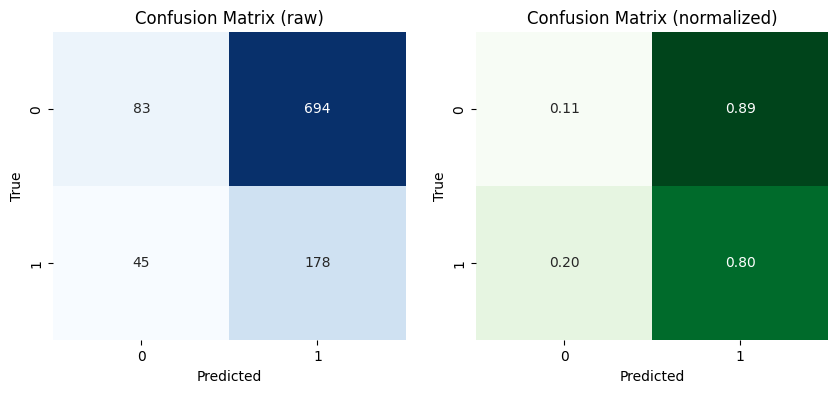


=== Detailed Classification Report ===
              precision    recall  f1-score   support

   Human (0)       0.65      0.11      0.18       777
 Machine (1)       0.20      0.80      0.33       223

    accuracy                           0.26      1000
   macro avg       0.43      0.45      0.25      1000
weighted avg       0.55      0.26      0.22      1000



In [ ]:
import os, numpy as np, pandas as pd, torch
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModel
from torch import nn
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --- Paths ---
test_path = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet"
ckpt_path = "/content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt"
model_name = "microsoft/codebert-base"

# --- Load test data ---
df_test = pd.read_parquet(test_path)
assert {"code","generator","label","language"}.issubset(df_test.columns)

# --- Tokenizer ---
tok = AutoTokenizer.from_pretrained(model_name)

# --- Model ---
class CodeBERTBinaryClassifier(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        h = self.encoder.config.hidden_size
        self.drop = nn.Dropout(0.1)
        self.cls = nn.Linear(h, 1)
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_vec = out.last_hidden_state[:,0,:]
        return self.cls(self.drop(cls_vec)).squeeze(-1)

model = CodeBERTBinaryClassifier(model_name)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device).eval()
print(f"✅ Loaded model from: {ckpt_path}")

# --- Dataset loader ---
class CodeDataset(torch.utils.data.Dataset):
    def __init__(self, df, tok, max_len=512):
        self.df, self.tok, self.max_len = df.reset_index(drop=True), tok, max_len
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        text = f"<lang:{row['language'].lower()}>\n{row['code']}"
        enc = self.tok(text, max_length=self.max_len, padding="max_length",
                       truncation=True, return_tensors="pt")
        return {"input_ids": enc["input_ids"].squeeze(0),
                "attention_mask": enc["attention_mask"].squeeze(0)}

loader = torch.utils.data.DataLoader(CodeDataset(df_test, tok), batch_size=32, shuffle=False)

# --- Inference ---
probs = []
with torch.no_grad():
    for b in tqdm(loader, desc="Scoring test", ncols=100):
        ids = b["input_ids"].to(device)
        attn = b["attention_mask"].to(device)
        logits = model(ids, attn)
        probs.extend(torch.sigmoid(logits).cpu().numpy())
probs = np.array(probs)

# --- Predicted labels (0/1) and true labels ---
threshold = 0.5
preds = (probs >= threshold).astype(int)

# if labels are textual, convert to numeric
y_true = df_test["label"].apply(lambda x: 1 if str(x).lower() in {"1","machine","ai","llm"} else 0).values

# --- Metrics summary ---
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_true, preds)
f1  = f1_score(y_true, preds, average="macro")
prec = precision_score(y_true, preds, average="macro")
rec  = recall_score(y_true, preds, average="macro")

print("\n=== Summary Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")

# --- Confusion matrix ---
cm = confusion_matrix(y_true, preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax[0])
ax[0].set_title("Confusion Matrix (raw)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens", cbar=False, ax=ax[1])
ax[1].set_title("Confusion Matrix (normalized)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
plt.show()

# --- Classification report ---
print("\n=== Detailed Classification Report ===")
print(classification_report(y_true, preds, target_names=["Human (0)","Machine (1)"]))

In [ ]:
# ===== Inference-only: add identifier-renaming ensemble + per-language thresholds + orientation selection =====
import os, re, gc, numpy as np, pandas as pd, torch
from dataclasses import dataclass
from typing import List, Tuple, Dict
from tqdm import tqdm
from torch import nn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

# ---------------- Config (EDIT PATHS IF NEEDED) ----------------
@dataclass
class Cfg:
    model_name: str = "microsoft/codebert-base"
    ckpt_path: str = "/content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt"

    val_parquet:  str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_validation_set.parquet"
    test_parquet: str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet"

    out_dir: str = "/content/drive/MyDrive/semeval_taskA_outputs"
    max_len: int = 512
    batch_size: int = 32
    num_workers: int = 2

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------------- Data utils ----------------
KW = {
    "python": set("""
False None True and as assert async await break class continue def del elif else
except finally for from global if import in is lambda nonlocal not or pass raise
return try while with yield print range len int float str list dict set tuple
""".split()),
    "java": set("""abstract assert boolean break byte case catch char class const continue
default do double else enum extends final finally float for goto if implements import instanceof int
interface long native new package private protected public return short static strictfp super switch synchronized this throw throws transient try void volatile while
""".split()),
    "cpp": set("""alignas alignof and and_eq asm atomic_cancel atomic_commit atomic_noexcept auto bitand bitor bool break case catch char char8_t char16_t char32_t class compl concept
const consteval constexpr constinit const_cast continue co_await co_return co_yield decltype default delete do double dynamic_cast else enum explicit export extern false float for friend goto if
inline int long mutable namespace new noexcept not not_eq nullptr operator or or_eq private protected public register reinterpret_cast requires return short signed sizeof static static_assert static_cast
struct switch synchronized template this thread_local throw true try typedef typeid typename union unsigned using virtual void volatile wchar_t while xor xor_eq
""".split()),
    "c": set("""auto break case char const continue default do double else enum extern float for goto if inline int long register restrict return short signed sizeof static struct switch typedef union unsigned void volatile while""".split()),
    "csharp": set("""abstract as base bool break byte case catch char checked class const continue decimal default delegate do double else enum event explicit extern false finally fixed float for foreach goto if implicit in int interface internal is lock long namespace new null object operator out override params private protected public readonly ref return sbyte sealed short sizeof stackalloc static string struct switch this throw true try typeof uint ulong unchecked unsafe ushort using virtual void volatile while""".split()),
    "javascript": set("""break case catch class const continue debugger default delete do else export extends finally for function if import in instanceof let new return super switch this throw try typeof var void while with yield""".split()),
    "php": set("""abstract and array as break callable case catch class clone const continue declare default die do echo else elseif empty enddeclare endfor endforeach endif endswitch endwhile eval exit extends final finally fn for foreach function global goto if implements include include_once instanceof insteadof interface isset list matches namespace new or print private protected public readonly require require_once return static switch throw trait try unset use var while xor yield""".split()),
    "go": set("""break case chan const continue default defer else fallthrough for func go goto if import interface map package range return select struct switch type var""".split()),
}
def normalize_language(s: str) -> str:
    t = str(s).strip().lower()
    t = {"py":"python","py3":"python","python3":"python","c++":"cpp","cs":"csharp","js":"javascript","node":"javascript","golang":"go"}.get(t, t)
    return t

def read_df(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path).copy()
    assert {"code","generator","label","language"}.issubset(df.columns)
    df["language"] = df["language"].apply(normalize_language)
    if "domain" not in df.columns:
        df["domain"] = "algorithmic"
    df["code"] = df["code"].astype(str)
    return df

def label_to_int(x):
    s = str(x).lower()
    if s in {"1","machine","ai","llm","generated"}: return 1
    if s in {"0","human"}: return 0
    raise ValueError(f"Unexpected label value: {x}")

# ---------------- Identifier renaming (safe-ish, consistent) ----------------
ID_RE = re.compile(r"\b[_a-zA-Z][_a-zA-Z0-9]*\b")

def rename_identifiers(code: str, lang: str, max_ids: int = 50) -> str:
    """
    Conservative, per-snippet consistent renamer:
    - skips keywords
    - skips very short names (len<=2)
    - only renames lowercase-starting identifiers (to avoid Types/ClassNames)
    """
    kws = KW.get(lang, set())
    mapping: Dict[str,str] = {}
    counter = 1

    def repl(m):
        nonlocal counter
        tok = m.group(0)
        if tok in kws: return tok
        if not tok[0].islower(): return tok
        if len(tok) <= 2: return tok
        if tok not in mapping:
            if counter > max_ids: return tok
            mapping[tok] = f"v{counter}"
            counter += 1
        return mapping[tok]

    try:
        return ID_RE.sub(repl, code)
    except Exception:
        return code

# ---------------- Ensemble variants ----------------
_comment_cpp_line = re.compile(r"//.*?$", flags=re.MULTILINE)
_comment_cpp_block = re.compile(r"/\*.*?\*/", flags=re.DOTALL)
_comment_hash = re.compile(r"#.*?$", flags=re.MULTILINE)
def strip_comments(text: str, lang: str) -> str:
    if lang == "python":
        return _comment_hash.sub("", text)
    return _comment_cpp_block.sub("", _comment_cpp_line.sub("", text))

def ws_tidy(text: str, lang: str) -> str:
    lines = text.splitlines()
    lines = [ln.rstrip() for ln in lines]
    out, blank = [], 0
    for ln in lines:
        if ln.strip()=="":
            blank += 1
            if blank <= 1: out.append(ln)
        else:
            blank = 0; out.append(ln)
    return "\n".join(out)

def make_variants(code: str, lang: str) -> List[str]:
    v = [code]
    try: v.append(strip_comments(code, lang))
    except: v.append(code)
    try: v.append(ws_tidy(code, lang))
    except: v.append(code)
    try: v.append(rename_identifiers(code, lang))
    except: v.append(code)
    return v

# ---------------- Model ----------------
class CodeBERTBinaryClassifier(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.tok = AutoTokenizer.from_pretrained(model_name)
        h = self.encoder.config.hidden_size
        self.drop = nn.Dropout(0.1)
        self.cls  = nn.Linear(h, 1)

    def logits_for_texts(self, texts: List[str]) -> torch.Tensor:
        enc = self.tok(texts, max_length=cfg.max_len, padding=True, truncation=True, return_tensors="pt").to(device)
        out = self.encoder(**enc)
        cls_vec = out.last_hidden_state[:,0,:]
        return self.cls(self.drop(cls_vec)).squeeze(-1)

# ---------------- Build data ----------------
val_df  = read_df(cfg.val_parquet)
test_df = read_df(cfg.test_parquet)
y_val   = val_df["label"].apply(label_to_int).values.astype(int)
y_test  = test_df["label"].apply(label_to_int).values.astype(int)

# ---------------- Load model ----------------
model = CodeBERTBinaryClassifier(cfg.model_name).to(device)
state = torch.load(cfg.ckpt_path, map_location=device)
model.load_state_dict(state); model.eval()
print(f"✅ Loaded checkpoint: {cfg.ckpt_path}")

# ---------------- Ensemble scorer ----------------
def ensemble_logits(df: pd.DataFrame) -> np.ndarray:
    logits_sum = np.zeros(len(df), dtype=np.float32)
    counts     = np.zeros(len(df), dtype=np.int32)
    batch_texts, idxs = [], []

    def flush():
        nonlocal batch_texts, idxs, logits_sum, counts
        if not batch_texts: return
        with torch.no_grad(), torch.amp.autocast(device_type="cuda", enabled=(device=="cuda")):
            lg = model.logits_for_texts(batch_texts).detach().float().cpu().numpy()
        for k, i in enumerate(idxs):
            logits_sum[i] += lg[k]; counts[i] += 1
        batch_texts, idxs = [], []

    for i, (code, lang) in enumerate(zip(df["code"], df["language"])):
        prefix = f"<lang:{lang}>\n"
        for txt in make_variants(code, lang):
            batch_texts.append(prefix + txt)
            idxs.append(i)
            if len(batch_texts) >= cfg.batch_size:
                flush()
    flush()
    return logits_sum / np.maximum(1, counts)

# ---------------- Score validation (ensemble) ----------------
print("Scoring validation with ensemble (4 variants)…")
val_logits = ensemble_logits(val_df); gc.collect(); torch.cuda.empty_cache()

# ---------------- Temperature scaling on validation ----------------
def fit_temperature(logits: np.ndarray, labels: np.ndarray, max_iter=100) -> float:
    x = torch.tensor(logits, dtype=torch.float32, device=device)
    y = torch.tensor(labels, dtype=torch.float32, device=device)
    T = torch.tensor(1.0, dtype=torch.float32, device=device, requires_grad=True)
    opt = torch.optim.LBFGS([T], lr=0.1, max_iter=max_iter, line_search_fn="strong_wolfe")
    bce = nn.BCEWithLogitsLoss()
    def closure():
        opt.zero_grad()
        loss = bce(x / T, y)
        loss.backward(); return loss
    opt.step(closure)
    t = float(T.detach().clamp_min(1e-3).cpu())
    return t

T = fit_temperature(val_logits, y_val)
val_probs = 1 / (1 + np.exp(-val_logits / T))
print(f"🔧 Temperature T = {T:.4f}")

# ---------------- Global & per-language thresholds (from VAL) ----------------
def best_threshold(y_true, y_prob):
    best_t, best_f1 = 0.5, -1.0
    for t in np.linspace(0,1,401):
        f1 = f1_score(y_true, (y_prob>=t).astype(int), average="macro")
        if f1 > best_f1: best_t, best_f1 = float(t), float(f1)
    return best_t, best_f1

t_global, f1g = best_threshold(y_val, val_probs)
print(f"🎯 Global best threshold: {t_global:.3f} (Val Macro-F1={f1g:.4f})")

per_lang_t: Dict[str,float] = {}
for L in sorted(np.unique(val_df["language"].values)):
    m = (val_df["language"].values==L)
    if m.sum() < 10:  # too few to tune
        per_lang_t[L] = t_global
        continue
    tL, f1L = best_threshold(y_val[m], val_probs[m])
    per_lang_t[L] = tL
    print(f"  - {L:>10}: t*={tL:.3f}  (n={m.sum():4d})")

# ---------------- Score TEST (ensemble + calibration) ----------------
print("Scoring test with ensemble (4 variants)…")
test_logits = ensemble_logits(test_df); gc.collect(); torch.cuda.empty_cache()
test_probs  = 1 / (1 + np.exp(-test_logits / T))

# Evaluate both orientations and keep the better one (since test is labeled)
def evaluate_with_orientation(y_true, probs, orientation: str):
    p = probs if orientation=="normal" else (1 - probs)
    # per-language thresholding
    langs = test_df["language"].values
    preds = np.zeros_like(y_true)
    for L in np.unique(langs):
        tL = per_lang_t.get(L, t_global)
        mask = (langs==L)
        preds[mask] = (p[mask] >= tL).astype(int)
    # metrics
    try: auroc = roc_auc_score(y_true, p)
    except: auroc = float("nan")
    res = dict(
        orientation=orientation,
        AUROC=auroc,
        AUPRC=average_precision_score(y_true, p),
        Acc=accuracy_score(y_true, preds),
        MacroF1=f1_score(y_true, preds, average="macro"),
        Prec=precision_score(y_true, preds, average="macro", zero_division=0),
        Rec=recall_score(y_true, preds, average="macro", zero_division=0),
        preds=preds, probs=p
    )
    return res

y_test = test_df["label"].apply(label_to_int).values.astype(int)
res_norm = evaluate_with_orientation(y_test, test_probs, "normal")
res_flip = evaluate_with_orientation(y_test, test_probs, "flipped")

best = res_flip if (res_flip["MacroF1"] > res_norm["MacroF1"]) else res_norm
print("\n=== TEST (choose best orientation automatically) ===")
for name, val in best.items():
    if name in {"preds","probs","orientation"}: continue
    print(f"{name}: {val:.4f}")
print("Chosen orientation:", best["orientation"])

# ---------------- Confusion matrix ----------------
cm = confusion_matrix(y_test, best["preds"])
cmn = cm / cm.sum(axis=1, keepdims=True)
print("\nConfusion matrix (raw):\n", cm)
print("\nConfusion matrix (normalized):\n", np.round(cmn,3))

# ---------------- Save CSV with predictions ----------------
out = test_df[["code","generator","label","language"]].copy()
# store calibrated prob in the chosen orientation
out["prob_machine_calibrated"] = best["probs"]
# preserve label type style
if np.issubdtype(test_df["label"].dtype, np.number):
    out["pred_label"] = best["preds"]
else:
    out["pred_label"] = np.where(best["preds"]==1, "machine", "human")
save_csv = os.path.join(cfg.out_dir, "taskA_test_with_predictions_calib_ensem_thres_oriented.csv")
out.to_csv(save_csv, index=False)
print(f"\nSaved predictions to: {save_csv}")

# ---------------- Per-language report ----------------
langs = test_df["language"].values
print("\n=== Per-language (TEST) using chosen orientation ===")
for L in sorted(np.unique(langs)):
    m = (langs==L)
    if m.sum()==0: continue
    y, p, yhat = y_test[m], best["probs"][m], best["preds"][m]
    try: au = roc_auc_score(y, p)
    except: au = float("nan")
    print(f"{L:>10}  n={m.sum():4d}  Acc={accuracy_score(y,yhat):.3f}  F1={f1_score(y,yhat,average='macro'):.3f}  AUROC={au:.3f}")

Device: cuda


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


✅ Loaded checkpoint: /content/drive/MyDrive/semeval_taskA_outputs/taskA_codebert_best.pt
Scoring validation with ensemble (4 variants)…
🔧 Temperature T = 1.2169
🎯 Global best threshold: 0.370 (Val Macro-F1=0.9954)
  -        cpp: t*=0.318  (n=4679)
  -       java: t*=0.135  (n=3860)
  -     python: t*=0.380  (n=91461)
Scoring test with ensemble (4 variants)…

=== TEST (choose best orientation automatically) ===
AUROC: 0.6086
AUPRC: 0.2803
Acc: 0.7380
MacroF1: 0.5484
Prec: 0.5722
Rec: 0.5468
Chosen orientation: flipped

Confusion matrix (raw):
 [[693  84]
 [178  45]]

Confusion matrix (normalized):
 [[0.892 0.108]
 [0.798 0.202]]

Saved predictions to: /content/drive/MyDrive/semeval_taskA_outputs/taskA_test_with_predictions_calib_ensem_thres_oriented.csv

=== Per-language (TEST) using chosen orientation ===
         c  n=  51  Acc=0.765  F1=0.627  AUROC=0.641
        c#  n= 122  Acc=0.811  F1=0.597  AUROC=0.824
       cpp  n=  75  Acc=0.773  F1=0.616  AUROC=0.572
        go  n=  60  Acc

# Task - 1 Attempt - 2

In [ ]:
import pandas as pd
import numpy as np
import os

# update these to your actual file paths:
train_path = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_training_set_1.parquet"
val_path   = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_validation_set.parquet"
test_path  = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet"

def describe_split(name, path):
    if not os.path.exists(path):
        print(f"❌ {name} not found at {path}")
        return None
    df = pd.read_parquet(path)
    print(f"\n=== {name.upper()} ({len(df):,} rows) ===")
    print("Columns:", list(df.columns))
    print("Null counts:\n", df.isnull().sum())
    print("\nSample rows:")
    print(df.head(2))
    print("\nLabel distribution:")
    print(df["label"].value_counts(dropna=False, normalize=True).round(3).to_dict() if "label" in df else "no label col")
    if "language" in df:
        print("\nLanguages (top 10):")
        print(df["language"].value_counts().head(10))
    if "generator" in df:
        print("\nGenerators (top 10):")
        print(df["generator"].value_counts().head(10))
    # code stats
    code_lens = df["code"].astype(str).apply(len)
    print(f"\nCode length: mean={code_lens.mean():.1f},  median={code_lens.median():.1f},  max={code_lens.max():,}")
    long = (code_lens > 10000).sum()
    if long:
        print(f"⚠️ {long} samples >10k chars")
    return df

train_df = describe_split("train", train_path)
val_df   = describe_split("validation", val_path)
test_df  = describe_split("test", test_path)

# class balance check
if train_df is not None and "label" in train_df:
    ratio = train_df["label"].value_counts(normalize=True)
    print("\nOverall train human/machine ratio:")
    print(ratio)


=== TRAIN (500,000 rows) ===
Columns: ['code', 'generator', 'label', 'language']
Null counts:
 code         0
generator    0
label        0
language     0
dtype: int64

Sample rows:
                                                code                generator  \
0  (a, b, c, d) = [int(x) for x in input().split(...                    human   
1  valid version for the language; all others can...  Qwen/Qwen2.5-Coder-1.5B   

   label language  
0      0   Python  
1      1   Python  

Label distribution:
{1: 0.523, 0: 0.477}

Languages (top 10):
language
Python    457306
C++        23392
Java       19302
Name: count, dtype: int64

Generators (top 10):
generator
human                                  238475
microsoft/Phi-3-medium-4k-instruct      16545
microsoft/Phi-3.5-mini-instruct          9869
01-ai/Yi-Coder-9B                        9815
bigcode/starcoder                        9780
microsoft/phi-2                          9494
Qwen/Qwen2.5-Coder-1.5B-Instruct         9017
bigcode/st

## Step 0 – Environment Setup (run first)

In [ ]:
# =====================================================================
# STEP 0 — Setup: installs, imports, config (A100, full data)
# =====================================================================
!pip -q install "transformers==4.43.4" "peft==0.12.0" "pyarrow" "pandas" "tqdm" "scikit-learn"

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os, random, json, math, time, re
from dataclasses import dataclass
from typing import Optional, List, Dict, Any

import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    f1_score, accuracy_score, confusion_matrix
)
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType

# reproducibility
SEED = 1337
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# A100 quality-of-life: allow TF32 (fast + stable)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", device)

@dataclass
class CFG:
    # paths
    train_path: str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_training_set_1.parquet"
    val_path:   str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_validation_set.parquet"  # ~100k
    test_path:  str = "/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet"

    # output
    out_dir:   str = "/content/drive/MyDrive/semeval_taskA_outputs_starcoder2_A100_full"
    ckpt_name: str = "taskA_starcoder2_A100_best.pt"

    # model
    model_name: str = "bigcode/starcoder2-3b"
    max_len:    int = 2048    # A100 can handle full 2k context comfortably

    # training (full-data defaults for A100)
    epochs:        int   = 1          # start with 2; you can raise to 3+ later
    batch_size:    int   = 1         # micro-batch per step
    grad_accum:    int   = 16         # effective batch = 4*16 = 64 sequences
    eval_bs:       int   = 1         # eval has no grad; raise to 24–32 if VRAM allows
    lr:            float = 5e-6
    warmup_ratio:  float = 0.06
    weight_decay:  float = 0.01
    max_grad_norm: float = 1.0

    # LoRA
    lora_r:        int   = 16
    lora_alpha:    int   = 32
    lora_dropout:  float = 0.05

    # features
    use_stylo:     bool  = True       # 24-D stylometrics
    lang_reweight: bool  = True       # inverse-freq per language

    # precision
    use_bf16:      bool  = True       # A100 supports bf16 → stable & fast

    # validation / training caps (FULL RUN => None)
    TRAIN_MAX_BATCHES: Optional[int] = None   # None = use ALL ~500k
    VAL_MAX_BATCHES:   Optional[int] = None   # None = use ALL ~100k
    FAST_VAL:          bool = False           # False = full validation passes

cfg = CFG()
os.makedirs(cfg.out_dir, exist_ok=True)
print(cfg)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 117.7 MB/s eta 0:00:00
Mounted at /content/drive
✅ Device: cuda
CFG(train_path='/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_training_set_1.parquet', val_path='/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_validation_set.parquet', test_path='/content/drive/MyDrive/SemEval-2026-Task13/task_a/task_a_test_set_sample.parquet', out_dir='/content/drive/MyDrive/semeval_taskA_outputs_starcoder2_A100_full', ckpt_name='taskA_starcoder2_A100_best.pt', model_name='bigcode/starcoder2-3b', max_len=2048, epochs=1, batch_size=1, grad_accum=16, eval_bs=1, lr=5e-06, warmup_ratio=0.06, weight_decay=0.01, max_grad_norm=1.0, lora_r=16, lora_alpha=32, lora_dropout=0.05, use_stylo=True, lang_reweig

## Step 1 – Configuration (L4 profile)

In [ ]:
# =====================================================================
# STEP 1 — Load parquet → DataFrames, normalize, clean code (A100/full)
# =====================================================================
def normalize_language(s: str) -> str:
    t = str(s if s is not None else "").strip().lower()
    return {
        "py":"python","py3":"python","python3":"python",
        "c++":"cpp","cs":"csharp","c#":"csharp",
        "js":"javascript","node":"javascript",
        "golang":"go"
    }.get(t, t)

LANG_NAMES = {"python","java","cpp","c","csharp","javascript","php","go"}
MAX_LINE_CHARS = 2000

def _is_bare_language_header(line: str) -> bool:
    s = str(line).strip().strip("`").lower()
    return s in LANG_NAMES

def clean_code(raw: str) -> str:
    if raw is None:
        return ""
    lines = str(raw).splitlines()
    # drop leading bare language header if present
    if lines:
        i = next((k for k, ln in enumerate(lines) if ln.strip() != ""), None)
        if i is not None and _is_bare_language_header(lines[i]):
            lines.pop(i)
    # clamp ultra-long lines (keeps structure, avoids crazy memory)
    clipped = []
    for ln in lines:
        ln = ln.rstrip()
        if len(ln) > MAX_LINE_CHARS:
            ln = ln[:MAX_LINE_CHARS]
        clipped.append(ln)
    return "\n".join(clipped)

def load_df(path: str) -> pd.DataFrame:
    # Read only what we need → lower RAM & faster IO
    df = pd.read_parquet(path, columns=["code","generator","label","language"]).copy()

    # basic hygiene
    df["code"] = df["code"].fillna("").astype(str).str.strip()
    df["language"] = df["language"].fillna("").apply(normalize_language)

    # optional domain (keep stable API)
    if "domain" not in df.columns:
        df["domain"] = "algorithmic"

    # clean code text
    df["code_clean"] = df["code"].apply(clean_code)

    # ensure strictly binary label → int8 (saves RAM)
    if np.issubdtype(df["label"].dtype, np.number):
        df["label_bin"] = df["label"].astype(int).clip(0, 1).astype(np.int8)
    else:
        def to_bin(x):
            s = str(x).strip().lower()
            if s in {"0","human"}: return 0
            if s in {"1","machine","ai","generated","llm"}: return 1
            raise ValueError(f"unexpected label: {x}")
        df["label_bin"] = df["label"].map(to_bin).astype(np.int8)

    return df

train_df = load_df(cfg.train_path)
val_df   = load_df(cfg.val_path)
test_df  = load_df(cfg.test_path)

print(f"TRAIN: {len(train_df):,}  VAL: {len(val_df):,}  TEST: {len(test_df):,}")
print("Train label ratio:", train_df["label_bin"].value_counts(normalize=True).to_dict())
print("Val   label ratio:",   val_df["label_bin"].value_counts(normalize=True).to_dict())
print("Test  label ratio:",  test_df["label_bin"].value_counts(normalize=True).to_dict())

# (Optional) quick per-language counts to spot imbalance
print("\nPer-language (train) top 10:")
print(train_df["language"].value_counts().head(10))

TRAIN: 500,000  VAL: 100,000  TEST: 1,000
Train label ratio: {1: 0.52305, 0: 0.47695}
Val   label ratio: {1: 0.52305, 0: 0.47695}
Test  label ratio: {0: 0.777, 1: 0.223}

Per-language (train) top 10:
language
python    457306
cpp        23392
java       19302
Name: count, dtype: int64


##  Step 2 (data prep)

In [ ]:
# =====================================================================
# STEP 2 — Tokenizer (make sure PAD exists and max length is aligned)
# =====================================================================
tok = AutoTokenizer.from_pretrained(cfg.model_name, use_fast=True)
tok.padding_side = "right"
tok.truncation_side = "right"

# StarCoder2 has no dedicated PAD — use EOS as PAD (safe for classification)
if tok.pad_token is None:
    # guard if eos also missing (very rare)
    if tok.eos_token is None:
        tok.add_special_tokens({"eos_token": "</s>"})
    tok.pad_token = tok.eos_token
    tok.pad_token_id = tok.eos_token_id

# keep tokenizer and our config in sync to avoid warnings
tok.model_max_length = cfg.max_len

print("Tokenizer:", tok.__class__.__name__,
      "| vocab:", tok.vocab_size,
      "| pad_token_id:", tok.pad_token_id,
      "| model_max_length:", tok.model_max_length)

# =====================================================================
# STEP 2b — Stylometrics (24-D) for optional fusion
# =====================================================================
KW = {
  "python": set("False None True and as assert async await break class continue def del elif else except finally for from global if import in is lambda nonlocal not or pass raise return try while with yield".split()),
  "java": set("abstract assert boolean break byte case catch char class const continue default do double else enum extends final finally float for goto if implements import instanceof int interface long native new package private protected public return short static strictfp super switch synchronized this throw throws transient try void volatile while".split()),
  "cpp": set("alignas alignof and and_eq asm atomic_cancel atomic_commit atomic_noexcept auto bitand bitor bool break case catch char char8_t char16_t char32_t class compl concept const consteval constexpr constinit const_cast continue co_await co_return co_yield decltype default delete do double dynamic_cast else enum explicit export extern false float for friend goto if inline int long mutable namespace new noexcept not not_eq nullptr operator or or_eq private protected public register reinterpret_cast requires return short signed sizeof static static_assert static_cast struct switch synchronized template this thread_local throw true try typedef typeid typename union unsigned using virtual void volatile wchar_t while xor xor_eq".split()),
  "c": set("auto break case char const continue default do double else enum extern float for goto if inline int long register restrict return short signed sizeof static struct switch typedef union unsigned void volatile while".split()),
  "csharp": set("abstract as base bool break byte case catch char checked class const continue decimal default delegate do double else enum event explicit extern false finally fixed float for foreach goto if implicit in int interface internal is lock long namespace new null object operator out override params private protected public readonly ref return sbyte sealed short sizeof stackalloc static string struct switch this throw true try typeof uint ulong unchecked unsafe ushort using virtual void volatile while".split()),
  "javascript": set("break case catch class const continue debugger default delete do else export extends finally for function if import in instanceof let new return super switch this throw try typeof var void while with yield".split()),
  "php": set("abstract and array as break callable case catch class clone const continue declare default die do echo else elseif empty enddeclare endfor endforeach endif endswitch endwhile eval exit extends final finally fn for foreach function global goto if implements include include_once instanceof insteadof interface isset list matches namespace new or print private protected public readonly require require_once return static switch throw trait try unset use var while xor yield".split()),
  "go": set("break case chan const continue default defer else fallthrough for func go goto if import interface map package range return select struct switch type var".split()),
}

ID_RE = re.compile(r"\b[_a-zA-Z][_a-zA-Z0-9]*\b")
COMMENT_HASH = re.compile(r"#.*?$", flags=re.MULTILINE)
COMMENT_CPP_LINE  = re.compile(r"//.*?$", flags=re.MULTILINE)
COMMENT_CPP_BLOCK = re.compile(r"/\*.*?\*/", flags=re.DOTALL)

def strip_comments(code: str, lang: str) -> str:
    if lang == "python":
        return COMMENT_HASH.sub("", code)
    txt = COMMENT_CPP_LINE.sub("", code)
    return COMMENT_CPP_BLOCK.sub("", txt)

def basic_stylo(code: str, lang: str) -> np.ndarray:
    # lengths/blank lines
    lines = code.splitlines() or [""]
    n = len(lines)
    lens = [len(x) for x in lines]
    num_blank = sum(1 for x in lines if x.strip() == "")

    # comments ratio
    code_nocom = strip_comments(code, lang)
    comment_len = max(0, len(code) - len(code_nocom))
    comment_ratio = comment_len / max(1, len(code))

    # identifiers & kw balance
    toks = ID_RE.findall(code)
    kws = KW.get(lang, set())
    idents = [t for t in toks if t not in kws]
    if idents:
        from collections import Counter
        counts = Counter(idents)
        p = np.array(list(counts.values()), dtype=np.float32); p = p / p.sum()
        ident_entropy = float(-(p * np.log2(p + 1e-9)).sum())
        avg_ident_len = sum(len(t) for t in idents) / len(idents)
        upper_ident_ratio = sum(t[0].isupper() for t in idents) / len(idents)
        snake_ratio = sum("_" in t for t in idents) / len(idents)
        camel_ratio = sum(re.search(r"[a-z][A-Z]", t) is not None for t in idents) / len(idents)
        digit_ident_ratio = sum(any(ch.isdigit() for ch in t) for t in idents) / len(idents)
    else:
        ident_entropy = avg_ident_len = upper_ident_ratio = snake_ratio = camel_ratio = digit_ident_ratio = 0.0

    # structure/indentation
    brace_balance = code.count("{") + code.count("(") + code.count("[") - (code.count("}") + code.count(")") + code.count("]"))
    indents = [len(ln) - len(ln.lstrip(" ")) for ln in lines]
    max_indent = float(max(indents)) if indents else 0.0
    avg_indent = float(sum(indents) / len(indents)) if indents else 0.0

    # repetition & entropy
    uniq_lines = len(set(lines))
    repeated_line_ratio = 1 - (uniq_lines / max(1, n))

    chars = list(code)
    if chars:
        from collections import Counter as C2
        c = C2(chars)
        p = np.array(list(c.values()), dtype=np.float32); p = p / p.sum()
        char_entropy = float(-(p * np.log2(p + 1e-9)).sum())
        alnum = sum(ch.isalnum() for ch in chars) / len(chars)
        symbol = sum(not ch.isalnum() and not ch.isspace() for ch in chars) / len(chars)
        runs = re.findall(r" +", code)
        avg_run_spaces = float(np.mean([len(r) for r in runs])) if runs else 0.0
    else:
        char_entropy = alnum = symbol = avg_run_spaces = 0.0

    # token stats
    tokens = re.findall(r"\w+|[^\w\s]", code, flags=re.UNICODE)
    uniq_tokens = len(set(tokens))
    token_uniq_ratio = uniq_tokens / max(1, len(tokens))
    token_lens = [len(t) for t in tokens] or [0]
    avg_token_len = float(np.mean(token_lens))
    trigrams = list(zip(tokens, tokens[1:], tokens[2:])) if len(tokens) >= 3 else []
    trigram_repeat_ratio = 1 - (len(set(trigrams)) / max(1, len(trigrams)))

    feat = np.array([
        n, float(np.mean(lens)), float(np.std(lens)), float(max(lens) if lens else 0.0),
        comment_ratio, num_blank / max(1, n),
        avg_ident_len, ident_entropy,
        sum(t in kws for t in toks) / max(1, len(toks)),
        upper_ident_ratio, snake_ratio, camel_ratio, digit_ident_ratio,
        float(brace_balance), max_indent, avg_indent,
        repeated_line_ratio, char_entropy, token_uniq_ratio, alnum, symbol,
        avg_token_len, trigram_repeat_ratio, avg_run_spaces
    ], dtype=np.float32)

    return np.nan_to_num(feat, nan=0.0, posinf=1e3, neginf=-1e3).astype(np.float32)

print("✅ Stylometrics ready (24-D).")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Tokenizer: GPT2TokenizerFast | vocab: 49152 | pad_token_id: 0 | model_max_length: 2048
✅ Stylometrics ready (24-D).


## Step 3 (tokenizer + dataloaders for StarCoder2 at 2048 tokens)

In [ ]:
# =====================================================================
# STEP 3 — Dataset & Dataloaders
# =====================================================================
class StarCoderDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int, use_stylo: bool):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len
        self.use_stylo = use_stylo

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i: int):
        row  = self.df.iloc[i]
        lang = row["language"]
        code = row.get("code_clean", row["code"])

        # prepend a lightweight language tag the model can latch onto
        text = f"<lang:{lang}>\n{code}"

        enc = self.tok(
            text,
            max_length=self.max_len,
            padding="max_length",   # stable VRAM; switch to "longest" + custom collate if you want dynamic padding
            truncation=True,
            return_tensors="pt",
        )

        item = {
            "input_ids":       enc["input_ids"].squeeze(0),
            "attention_mask":  enc["attention_mask"].squeeze(0),
            "label":           torch.tensor(int(row["label_bin"]), dtype=torch.float32),  # float for BCEWithLogits
            "language":        lang,
        }
        if cfg.use_stylo:
            item["stylo"] = torch.tensor(basic_stylo(code, lang), dtype=torch.float32)

        # quick sanity: attn mask is 0/1
        # (comment this assert out if you’re micro-optimizing speed)
        am = item["attention_mask"]
        if torch.numel(am) and not torch.all((am == 0) | (am == 1)):
            raise ValueError("attention_mask contains values other than {0,1}")

        return item


# ---- Dataloaders (stable defaults for Colab/A100) ----
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(
    StarCoderDataset(train_df, tok, cfg.max_len, cfg.use_stylo),
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=0,               # set >0 if your runtime is stable and disk is fast
    pin_memory=True,
    persistent_workers=False,
    generator=g,
)

val_loader = DataLoader(
    StarCoderDataset(val_df, tok, cfg.max_len, cfg.use_stylo),
    batch_size=cfg.eval_bs,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
)

test_loader = DataLoader(
    StarCoderDataset(test_df, tok, cfg.max_len, cfg.use_stylo),
    batch_size=cfg.eval_bs,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
)

print(f"batches → train={len(train_loader)}  val={len(val_loader)}  test={len(test_loader)}")

# quick sanity
b = next(iter(train_loader))
vsz = tok.vocab_size
assert b["input_ids"].min().item() >= 0 and b["input_ids"].max().item() < vsz
assert set(np.unique(b["attention_mask"].numpy()).tolist()) <= {0,1}
print("✅ batch OK | ids:", tuple(b["input_ids"].shape), "| attn:", tuple(b["attention_mask"].shape))

batches → train=500000  val=100000  test=1000
✅ batch OK | ids: (1, 2048) | attn: (1, 2048)


## Step 4 — StarCoder2-3B + LoRA classification head

In [ ]:
# === STEP 4 — Build StarCoder2-3B + LoRA binary classifier (lean + stable) ===
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType

# Free any previous model
for n in ["model", "base"]:
    if n in globals():
        del globals()[n]
torch.cuda.empty_cache()

# 1) Load base LM (bf16 on Ampere/Lovelace if enabled, else fp16)
amp_dtype = torch.bfloat16 if getattr(cfg, "use_bf16", False) else torch.float16
base = AutoModelForCausalLM.from_pretrained(
    cfg.model_name,
    torch_dtype=amp_dtype,
    device_map=None
).to(device)

# 2) Make tokenizer/model consistent
base.resize_token_embeddings(len(tok))
base.config.pad_token_id = tok.pad_token_id
base.config.eos_token_id = tok.eos_token_id
base.config.use_cache    = False  # must be False when using grad checkpointing

# 3) Pick LoRA target modules that actually exist — prefer only attention proj heads to save VRAM
candidates_all = ["q_proj","k_proj","v_proj","o_proj","c_proj","fc_in","fc_out","out_proj"]
present = [name.split(".")[-1] for name, _ in base.named_modules() if name.split(".")[-1] in candidates_all]
present = sorted(set(present))
# keep only q/k/v/o if available (best bang-for-buck); fall back to whatever is present
preferred = [m for m in ["q_proj","k_proj","v_proj","o_proj","c_proj"] if m in present]
target_modules = preferred if len(preferred) >= 3 else (present if present else cfg.lora_target_modules)
print("LoRA targets:", target_modules)

# 4) LoRA config & wrap
peft_cfg = LoraConfig(
    r=cfg.lora_r,
    lora_alpha=cfg.lora_alpha,
    lora_dropout=cfg.lora_dropout,
    target_modules=target_modules,
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
)
base = get_peft_model(base, peft_cfg)

# 5) Small binary head on pooled last hidden (optionally fuse 24-D stylometrics)
class BinaryHead(nn.Module):
    def __init__(self, hidden_size: int, use_stylo: bool, stylo_dim: int = 24):
        super().__init__()
        self.use_stylo = use_stylo
        in_dim = hidden_size + (stylo_dim if use_stylo else 0)
        self.net = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 1),
        )
    def forward(self, pooled: torch.Tensor, stylo: torch.Tensor | None):
        if self.use_stylo and (stylo is not None):
            pooled = torch.cat([pooled, stylo], dim=1)
        return self.net(pooled).squeeze(-1)

class StarcoderDetector(nn.Module):
    def __init__(self, lm, use_stylo=True, stylo_dim=24):
        super().__init__()
        self.lm = lm
        self.use_stylo = use_stylo
        self.head = BinaryHead(lm.config.hidden_size, use_stylo, stylo_dim)
    def forward(self, input_ids, attention_mask, stylo=None):
        out = self.lm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True,
        )
        h = out.hidden_states[-1]            # [B, L, H]
        mask = attention_mask.unsqueeze(-1)  # [B, L, 1]
        pooled = (h * mask).sum(1) / mask.sum(1).clamp(min=1)  # mean-pool
        return self.head(pooled, stylo)

model = StarcoderDetector(base, use_stylo=cfg.use_stylo, stylo_dim=24).to(device)

# 6) Freeze all but LoRA + head
for n, p in model.named_parameters():
    if ("lora" in n.lower()) or ("adapter" in n.lower()) or ("head" in n.lower()):
        p.requires_grad_(True)
    else:
        p.requires_grad_(False)

# 7) Enable gradient checkpointing (big memory saver for long sequences)
try:
    model.lm.gradient_checkpointing_enable()
    # also recommended when using checkpointing with HF models
    if hasattr(model.lm, "enable_input_require_grads"):
        model.lm.enable_input_require_grads()
    print("✓ gradient checkpointing enabled; use_cache=False")
except Exception as e:
    print("! could not enable gradient checkpointing:", repr(e))

# 8) Friendly summary
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable:,} / {total:,}  ({trainable/total:.2%})")

# 9) Fast math (safe on Ampere/Lovelace/Hopper)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/12.1G [00:00<?, ?B/s]

LoRA targets: ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'c_proj']
✓ gradient checkpointing enabled; use_cache=False
Trainable: 18,052,097 / 3,048,423,425  (0.59%)


##  Step 5 — Train + Save Best (fp16 AMP, grad-accum, StarCoder2-3B + LoRA)

In [ ]:
# --- VRAM-safe knobs (L4) ---
import os, torch
from torch.utils.data import DataLoader

# 1) Make allocations less bursty and allow TF32 matmul
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# 2) Tighten sequence length and micro-batch training
cfg.max_len     = min(getattr(cfg, "max_len", 1536), 1024)  # 1024 is much safer than 1536/2048 on L4
cfg.batch_size  = 8                                         # micro-batch = 1
cfg.grad_accum  = max(getattr(cfg, "grad_accum", 8), 16)    # keep effective batch via accumulation
cfg.eval_bs     = 8                                         # eval can be >1 (no grads)

# 3) If needed, you can temporarily disable stylo to shave tiny compute (VRAM difference is small)
# cfg.use_stylo = False

# 4) Rebuild dataloaders with the new batch sizes
train_loader = DataLoader(StarCoderDataset(train_df, tok, cfg.max_len, cfg.use_stylo),
                          batch_size=cfg.batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(StarCoderDataset(val_df, tok, cfg.max_len, cfg.use_stylo),
                          batch_size=cfg.eval_bs, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(StarCoderDataset(test_df, tok, cfg.max_len, cfg.use_stylo),
                          batch_size=cfg.eval_bs, shuffle=False, num_workers=0, pin_memory=True)

print(f"✅ loaders rebuilt: train={len(train_loader)} iters, val={len(val_loader)} iters, test={len(test_loader)} iters")
print(f"cfg.max_len={cfg.max_len} | train bs={cfg.batch_size} | grad_accum={cfg.grad_accum} | eval bs={cfg.eval_bs}")

# 5) Enable gradient checkpointing on the base LM and disable cache
try:
    model.lm.gradient_checkpointing_enable()
    model.lm.config.use_cache = False
    print("✓ gradient checkpointing enabled; use_cache=False")
except Exception as e:
    print("! could not enable gradient checkpointing:", repr(e))

# 6) Show effective tokens per optimizer step (for sanity)
eff_tokens = cfg.batch_size * cfg.grad_accum * cfg.max_len
print(f"~ effective tokens/optimizer-step ≈ {eff_tokens:,}")

✅ loaders rebuilt: train=62500 iters, val=12500 iters, test=125 iters
cfg.max_len=1024 | train bs=8 | grad_accum=16 | eval bs=8
✓ gradient checkpointing enabled; use_cache=False
~ effective tokens/optimizer-step ≈ 131,072


In [ ]:
# =====================================================================
# STEP 5 — Train (caps or full), VAL/TEST, CSV — FIXED
# =====================================================================
from typing import Optional
import os, numpy as np, pandas as pd, torch
from tqdm.auto import tqdm
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ----- precision for autocast -----
AMP_DTYPE = torch.bfloat16 if (getattr(cfg, "use_bf16", False) and torch.cuda.is_bf16_supported()) else torch.float16

# ----- speed / memory knobs (edit as you like) -----
TRAIN_MAX_BATCHES = 6250       # None = full epoch; set e.g. 4000 for a quick pass
VAL_MAX_BATCHES   = 3125       # None = full validation; set e.g. 2000 for quick val

# (If you run out of memory at start of training, you can temporarily do:
# cfg.max_len = min(cfg.max_len, 1024); cfg.grad_accum = max(cfg.grad_accum, 16))

# ----- rebuild (larger) VAL/TEST loaders if needed -----
from torch.utils.data import DataLoader
VAL_BS, TEST_BS = cfg.eval_bs, cfg.eval_bs  # keep what you set in CFG
val_loader  = DataLoader(val_loader.dataset,  batch_size=VAL_BS,  shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_loader.dataset, batch_size=TEST_BS, shuffle=False, num_workers=0, pin_memory=True)
print(f"VAL batches:  {len(val_loader)}  (bs={VAL_BS})")
print(f"TEST batches: {len(test_loader)} (bs={TEST_BS})")

# ----- per-language inverse-frequency weights (sqrt), mean≈1 -----
lang_counts = pd.concat([train_df, val_df], ignore_index=True)["language"].value_counts().to_dict()
lang_w = {L: (1.0 / (c ** 0.5)) for L, c in lang_counts.items()}
mw = sum(lang_w.values()) / max(1, len(lang_w))
lang_w = {k: v / max(mw, 1e-8) for k, v in lang_w.items()}

def batch_lang_w(batch_langs):
    if not cfg.lang_reweight:
        return None
    return torch.tensor([lang_w.get(L, 1.0) for L in batch_langs], dtype=torch.float32, device=device)

# ----- optimizer & scheduler -----
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=cfg.lr, weight_decay=cfg.weight_decay)

total_train_batches = len(train_loader) if TRAIN_MAX_BATCHES is None else min(len(train_loader), TRAIN_MAX_BATCHES)
total_steps  = (total_train_batches * cfg.epochs) // max(1, cfg.grad_accum)
warmup_steps = int(cfg.warmup_ratio * total_steps)
scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

VOCAB = tok.vocab_size
def sanitize(ids, attn):
    attn = attn.long().clamp_(0, 1)
    if ids.max().item() >= VOCAB or ids.min().item() < 0:
        ids = ids.clone().clamp_(0, VOCAB - 1)
    return ids, attn

def metrics_bin(y_true, y_prob, thr=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    try:
        auroc = roc_auc_score(y_true, y_prob)
    except Exception:
        auroc = float("nan")
    auprc = average_precision_score(y_true, y_prob)
    y_pred = (y_prob >= thr).astype(int)
    return dict(
        AUROC=float(auroc),
        AUPRC=float(auprc),
        MacroF1=float(f1_score(y_true, y_pred, average="macro")),
        Accuracy=float(accuracy_score(y_true, y_pred)),
    ), y_pred

def train_epoch(ep: int):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    running, steps, skipped, opt_steps = 0.0, 0, 0, 0
    n_batches = len(train_loader) if TRAIN_MAX_BATCHES is None else min(len(train_loader), TRAIN_MAX_BATCHES)

    with tqdm(total=n_batches, desc=f"Epoch {ep}", unit="batch") as pbar:
        for i, batch in enumerate(train_loader):
            if (TRAIN_MAX_BATCHES is not None) and (i >= TRAIN_MAX_BATCHES):
                break

            ids   = batch["input_ids"].to(device, non_blocking=True)
            attn  = batch["attention_mask"].to(device, non_blocking=True)
            lab   = batch["label"].float().to(device, non_blocking=True)
            sty   = batch.get("stylo")
            sty   = (sty.to(device, non_blocking=True) if (sty is not None and cfg.use_stylo) else None)

            w_ex = batch_lang_w(batch["language"])
            if w_ex is None:
                w_ex = torch.ones_like(lab, device=device)

            ids, attn = sanitize(ids, attn)

            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
                logits = model(ids, attn, stylo=sty)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(
                    logits.float(), lab.float(), weight=w_ex.float()
                )

            if not torch.isfinite(loss):
                skipped += 1
                optimizer.zero_grad(set_to_none=True)
                pbar.set_postfix(loss="nan", skipped=skipped); pbar.update(1)
                continue

            loss.backward()

            if (i + 1) % cfg.grad_accum == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()
                opt_steps += 1

            # light VRAM defrag every 200 steps
            if (i + 1) % 200 == 0:
                torch.cuda.empty_cache()

            running += float(loss.item()); steps += 1
            pbar.set_postfix(loss=running / max(1, steps), skipped=skipped); pbar.update(1)

    return running / max(1, steps), skipped

@torch.no_grad()
def eval_epoch(loader, desc="Validating", thr=0.5, max_batches: Optional[int] = None):
    model.eval()
    probs, labels, langs = [], [], []
    n_batches = len(loader) if (max_batches is None) else min(len(loader), max_batches)
    with tqdm(total=n_batches, desc=desc, unit="batch") as pbar:
        for i, batch in enumerate(loader):
            if (max_batches is not None) and (i >= max_batches):
                break
            ids  = batch["input_ids"].to(device, non_blocking=True)
            attn = batch["attention_mask"].to(device, non_blocking=True)
            sty  = batch.get("stylo")
            sty  = (sty.to(device, non_blocking=True) if (sty is not None and cfg.use_stylo) else None)
            ids, attn = sanitize(ids, attn)
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
                logits = model(ids, attn, stylo=sty)
            probs.extend(torch.sigmoid(logits).float().cpu().numpy().tolist())
            labels.extend(batch["label"].cpu().numpy().tolist())
            langs.extend(list(batch["language"]))
            pbar.update(1)
    metrics, preds = metrics_bin(labels, probs, thr=thr)
    return metrics, np.array(labels), np.array(probs), np.array(preds), np.array(langs)

# ----- Train + Save best by MacroF1 -----
best_f1, best_state = -1.0, None
for ep in range(1, cfg.epochs + 1):
    tr_loss, skipped = train_epoch(ep)

    val_cap = VAL_MAX_BATCHES  # None → full val
    val_metrics, v_labels, v_probs, v_preds, v_langs = eval_epoch(
        val_loader, desc="Validating (VAL)", thr=0.5, max_batches=val_cap
    )
    print(f"\nEpoch {ep}/{cfg.epochs} | skipped={skipped} | TrainLoss {tr_loss:.4f} | "
          f"VAL → AUROC {val_metrics['AUROC']:.4f}  AUPRC {val_metrics['AUPRC']:.4f}  "
          f"F1 {val_metrics['MacroF1']:.4f}  Acc {val_metrics['Accuracy']:.4f}")

    if val_metrics["MacroF1"] > best_f1:
        best_f1 = val_metrics["MacroF1"]
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        print("** new best checkpoint cached **")

# save best
os.makedirs(cfg.out_dir, exist_ok=True)
ckpt_path = os.path.join(cfg.out_dir, cfg.ckpt_name)
if best_state is not None:
    model.load_state_dict(best_state); model.to(device)
    torch.save(best_state, ckpt_path)
    print("✅ Saved best to:", ckpt_path)
else:
    print("⚠️ No best state captured — check logs.")

# ----- Final VAL (full) -----
final_val_metrics, v_labels, v_probs, v_preds, v_langs = eval_epoch(
    val_loader, desc="Scoring VAL (final)", thr=0.5, max_batches=3125
)
print("\n=== VAL (final) ===")
print(final_val_metrics)
print("\nConfusion matrix (VAL):\n", confusion_matrix(v_labels, v_preds, labels=[0,1]))

# ----- TEST + CSV -----
test_metrics, t_labels, t_probs, t_preds, t_langs = eval_epoch(
    test_loader, desc="Scoring TEST", thr=0.5, max_batches=None
)
print("\n=== TEST ===")
print(test_metrics)

test_out = test_df.copy()
test_out["prob_machine"] = t_probs
test_out["pred_label"]   = t_preds
csv_path = os.path.join(cfg.out_dir, "taskA_test_with_predictions_starcoder2.csv")
test_out.to_csv(csv_path, index=False)
print("📄 wrote:", csv_path)

print("\nConfusion matrix (TEST):\n", confusion_matrix(t_labels, t_preds, labels=[0,1]))

print("\n=== Per-language (TEST) ===")
for lang in sorted(pd.unique(pd.Series(t_langs))):
    m = (t_langs == lang)
    if m.sum() == 0:
        continue
    met, _ = metrics_bin(t_labels[m], t_probs[m])
    print(f"{lang:>10s}  n={m.sum():5d}  Acc={met['Accuracy']:.3f}  F1={met['MacroF1']:.3f}  AUROC={met['AUROC']:.3f}")

VAL batches:  12500  (bs=8)
TEST batches: 125 (bs=8)


Epoch 1:   0%|          | 0/6250 [00:00<?, ?batch/s]

Validating (VAL):   0%|          | 0/3125 [00:00<?, ?batch/s]


Epoch 1/1 | skipped=0 | TrainLoss 0.1524 | VAL → AUROC 0.9630  AUPRC 0.9712  F1 0.9134  Acc 0.9137
** new best checkpoint cached **
✅ Saved best to: /content/drive/MyDrive/semeval_taskA_outputs_starcoder2_A100_full/taskA_starcoder2_A100_best.pt


Scoring VAL (final):   0%|          | 0/3125 [00:00<?, ?batch/s]


=== VAL (final) ===
{'AUROC': 0.962994821365011, 'AUPRC': 0.9711613177017148, 'MacroF1': 0.9134237898266615, 'Accuracy': 0.91368}

Confusion matrix (VAL):
 [[10741  1287]
 [  871 12101]]


Scoring TEST:   0%|          | 0/125 [00:00<?, ?batch/s]


=== TEST ===
{'AUROC': 0.7234101494191181, 'AUPRC': 0.4590283249626303, 'MacroF1': 0.49994938758983704, 'Accuracy': 0.506}
📄 wrote: /content/drive/MyDrive/semeval_taskA_outputs_starcoder2_A100_full/taskA_test_with_predictions_starcoder2.csv

Confusion matrix (TEST):
 [[308 469]
 [ 25 198]]

=== Per-language (TEST) ===
         c  n=   51  Acc=0.667  F1=0.630  AUROC=0.877
       cpp  n=   75  Acc=0.613  F1=0.577  AUROC=0.828
    csharp  n=  122  Acc=0.508  F1=0.505  AUROC=0.757
        go  n=   60  Acc=0.833  F1=0.740  AUROC=0.824
      java  n=  256  Acc=0.492  F1=0.467  AUROC=0.758
javascript  n=   85  Acc=0.494  F1=0.464  AUROC=0.608
       php  n=   48  Acc=0.292  F1=0.271  AUROC=0.663
    python  n=  303  Acc=0.436  F1=0.434  AUROC=0.760


## STEP 6 — Threshold tuning on VAL → final TEST + CSV

In [ ]:
# === STEP 6 — Tune threshold on VAL, then score TEST + write CSV ===
import numpy as np, pandas as pd, torch, os
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
AMP_DTYPE = torch.bfloat16 if getattr(cfg, "use_bf16", False) and torch.cuda.is_bf16_supported() else torch.float16
VOCAB = tok.vocab_size

def sanitize(ids, attn, vocab_size=VOCAB):
    attn = attn.long().clamp_(0,1)
    if ids.max().item() >= vocab_size or ids.min().item() < 0:
        ids = ids.clone().clamp_(0, vocab_size-1)
    return ids, attn

def metrics_bin(y_true, y_prob, thr=0.5):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
    try:
        auroc = roc_auc_score(y_true, y_prob)
    except Exception:
        auroc = float("nan")
    auprc = average_precision_score(y_true, y_prob)
    y_pred = (y_prob >= thr).astype(int)
    return dict(AUROC=float(auroc), AUPRC=float(auprc),
                MacroF1=float(f1_score(y_true, y_pred, average="macro")),
                Accuracy=float(accuracy_score(y_true, y_pred))), y_pred

@torch.no_grad()
def score_loader(loader, desc="Scoring"):
    model.eval()
    probs, labels, langs = [], [], []
    with tqdm(total=len(loader), desc=desc, unit="batch") as pbar:
        for batch in loader:
            ids  = batch["input_ids"].to(device, non_blocking=True)
            attn = batch["attention_mask"].to(device, non_blocking=True)
            sty  = batch.get("stylo")
            sty  = (sty.to(device, non_blocking=True) if (sty is not None and cfg.use_stylo) else None)
            ids, attn = sanitize(ids, attn)
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
                logits = model(ids, attn, stylo=sty)
            probs.extend(torch.sigmoid(logits).float().cpu().numpy().tolist())
            labels.extend(batch["label"].cpu().numpy().tolist())
            langs.extend(list(batch["language"]))
            pbar.update(1)
    return np.array(labels), np.array(probs), np.array(langs)

# 1) VAL: get full probabilities
v_labels, v_probs, v_langs = score_loader(val_loader, desc="Scoring VAL (full for threshold)")

# 2) Tune threshold to maximize Macro-F1 on VAL
cand = np.linspace(0.05, 0.95, 181)  # 0.005 step
best_f1, best_t = -1.0, 0.5
for t in cand:
    met, _ = metrics_bin(v_labels, v_probs, thr=t)
    if met["MacroF1"] > best_f1:
        best_f1, best_t = met["MacroF1"], t

print(f"\n🎯 Tuned threshold on VAL: t* = {best_t:.3f}  (VAL Macro-F1={best_f1:.4f})")

# 3) Final VAL report @ tuned threshold
val_metrics, v_preds = metrics_bin(v_labels, v_probs, thr=best_t)
from sklearn.metrics import confusion_matrix
print("\n=== VAL (tuned) ===")
print(val_metrics)
print("Confusion matrix (VAL):\n", confusion_matrix(v_labels, v_preds, labels=[0,1]))

# 4) TEST: score fully and apply tuned threshold
t_labels, t_probs, t_langs = score_loader(test_loader, desc="Scoring TEST (final)")
test_metrics, t_preds = metrics_bin(t_labels, t_probs, thr=best_t)
print("\n=== TEST (tuned threshold) ===")
print(test_metrics)
print("Confusion matrix (TEST):\n", confusion_matrix(t_labels, t_preds, labels=[0,1]))

# 5) Write TEST CSV
test_out = test_df.copy()
test_out["prob_machine"] = t_probs
test_out["pred_label"]   = t_preds
os.makedirs(cfg.out_dir, exist_ok=True)
csv_path = os.path.join(cfg.out_dir, f"taskA_test_with_predictions_starcoder2_t{best_t:.3f}.csv")
test_out.to_csv(csv_path, index=False)
print("📄 wrote:", csv_path)

Scoring VAL (full for threshold):   0%|          | 0/12500 [00:00<?, ?batch/s]

KeyboardInterrupt: 